In [1]:
import laspy
import numpy as np

## Merge the two point clouds
We used the (data fusion project) to label objects in the point cloud with the classes: !!TODO!!. It is unknown to which classes the remaining points belong. Therefore, we use the M3C2 algorithm in CloudCompare to remove non-static objects from the point cloud data.


In [2]:
cloud_labelled = '../datasets/pointclouds/processed_2386_9702.laz'
cloud_m3c2 = '../datasets/pointclouds/processed_2386_9702_m3c2.laz'

In [3]:
def read_pointcloud(las_path, jm=False):
    pointcloud = laspy.read(las_path)

    if 'label' not in pointcloud.point_format.extra_dimension_names:
        labels = np.zeros((len(pointcloud.x),), dtype='uint16')
    else:
        labels = pointcloud.label

    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z, labels)).T
    
    if jm:
        exclude_label = 0
        mask = labels != exclude_label
        points = points[mask, :]

    return points

def merge_pointclouds(arr1, arr2):
    # Concatenating operation
    # axis = 1 implies that it is being done column-wise
    merged = np.concatenate((arr1, arr2), axis=0)
    return merged
    
def write_las(points, labels, las_path):
    """
    Saving the ndarray points data into a .las file.
    :param content: ndarray
    :param las_path: string, path to save the las file
    """
    print('Saving LAS lidar data')
    
    outfile = laspy.create(file_version="1.2", point_format=3)
    outfile.x = points[:, 0]
    outfile.y = points[:, 1]
    outfile.z = points[:, 2]
    outfile.add_extra_dim(laspy.ExtraBytesParams(name="label", type="uint16",
                          description="Labels"))
    outfile.label = labels
    outfile.write(las_path)
    
een = read_pointcloud(cloud_labelled, True)
twee = read_pointcloud(cloud_m3c2)

merged = merge_pointclouds(een, twee)

write_las(merged[:, [0,1,2]], merged[:, 3], 'jm.laz')

Saving LAS lidar data


## Scrape and parse reference data from BGT
Download sidewalk data


In [4]:
# Add project src to path.
#import set_path

import upcp.scrapers.ams_bgt_scraper as ams_bgt_scraper
import upcp.scrapers.ndw_scraper as ndw_scraper
import upcp.utils.las_utils as las_utils
import upcp.utils.csv_utils as csv_utils
import upcp.utils.bgt_utils as bgt_utils
import upcp.utils.ahn_utils as ahn_utils
from upcp.utils import clip_utils

In [5]:
# Single file
tilecode = '2386_9702'
bbox = las_utils.get_bbox_from_tile_code(tilecode, padding=0)

In [6]:
# Output file for the BGT fuser.
bgt_data_file = '../datasets/bgt/bgt_voetpad_demo.csv'
csv_headers = ['bgt_name', 'polygon', 'x_min', 'y_max', 'x_max', 'y_min']
    
# Road and parking spots layers in BGT
bgt_layers = ['BGT_WGL_voetpad']

In [7]:
# Scrape data from the Amsterdam WFS and parse the json.
bgt_road_polygons_csv = []
for layer in bgt_layers:
    # Scrape data from the Amsterdam WFS, this will return a json response.
    json_content = ams_bgt_scraper.scrape_amsterdam_bgt(layer, bbox=bbox)
    
    # Parse the downloaded json response.
    parsed_content = ams_bgt_scraper.parse_polygons(json_content)
    bgt_road_polygons_csv += parsed_content

# Write the csv
csv_utils.write_csv(bgt_data_file, bgt_road_polygons_csv, csv_headers)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Filter all the points in the point cloud above sidewalk
(NOTE: same code as building fuser)

In [8]:
import matplotlib.pyplot as plt

In [9]:
# Create reader for BGT road part polygons.
bgt_road_file = '../datasets/bgt/bgt_voetpad_demo.csv'
bgt_sidewalk_reader = bgt_utils.BGTPolyReader(bgt_file=bgt_road_file)

sidewalk_polygons = bgt_sidewalk_reader.filter_tile(
                            tilecode, bgt_types=['voetpad'],
                            padding=0, offset=0,
                            merge=False)

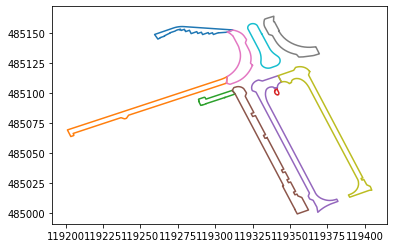

In [10]:
for poly in sidewalk_polygons:
    x,y = poly.exterior.xy
    plt.plot(x,y)

In [11]:
# We need elevation data to determine object height above ground.
ahn_data_folder = '../datasets/ahn/'
ahn_reader = ahn_utils.NPZReader(ahn_data_folder)

In [12]:
def get_label_mask(points, mask, tilecode, sidewalk_polygons, ahn_reader):
    ahn_eps = 0.2
    
    label_mask = np.zeros((len(points),), dtype=bool)

    if len(sidewalk_polygons) == 0:
        print('No sidewalk polygons found for tile, skipping.')
        return label_mask

    if mask is None:
        mask = np.ones((len(points),), dtype=bool)
    mask_ids = np.where(mask)[0]

    obstacle_mask = np.zeros((len(mask_ids),), dtype=bool)
    for polygon in sidewalk_polygons:
        clip_mask = clip_utils.poly_clip(points[mask, :], polygon)
        obstacle_mask = obstacle_mask | clip_mask

    # TODO remove 
    if ahn_reader is not None:
        bld_z = ahn_reader.interpolate(
            tilecode, points[mask, :], mask, 'ground_surface')
        bld_z_valid = np.isfinite(bld_z)
        ahn_mask = (points[mask_ids[bld_z_valid], 2]
                    <= bld_z[bld_z_valid] + 4) # Alles boven de 4 meter boven de grond
        obstacle_mask[bld_z_valid] = obstacle_mask[bld_z_valid] & ahn_mask

    label_mask[mask_ids[obstacle_mask]] = True

    return label_mask

def create_mask(labels, exclude_labels):
    """Create mask based on `exclude_labels`."""
    mask = np.ones((len(labels),), dtype=bool)
    if len(exclude_labels) > 0:
        for exclude_label in exclude_labels:
            mask = mask & (labels != exclude_label)
    return mask

labels = merged[:, 3]
exclude_label = [1, 2, 7] # We need to ignore ground, buildings and cars
mask = create_mask(labels, exclude_label)

# Mask obstacles
label_mask = get_label_mask(merged[:, [0,1,2]], mask, tilecode, sidewalk_polygons, ahn_reader)

labels[label_mask] = 33

write_las(merged[:, [0,1,2]], labels, 'sidewalk_filter.laz')

Saving LAS lidar data


## Obstacle detection on sidewalks based change detection and BGT information

In [13]:
# We need elevation data to determine object height above ground.
ahn_data_folder = '../datasets/ahn/'
ahn_reader = ahn_utils.NPZReader(ahn_data_folder)

In [14]:
mask = (labels == 33)

In [15]:
from accessibility import Accessibility

In [17]:
# Min and max height above AHN plane
obstacle_params = {'min_height': 0, 'max_height': 1.8}

# 3D Obstacle blobs to 2D polygons using a clustering algorithm and BGT road data.
accesibility_class = Accessibility(33, ahn_reader, min_component_size=100, bgt_file=bgt_data_file, grid_size=0.05,
                            params=obstacle_params)

label_mask = accesibility_class.get_obstacle_polygons(merged[:, [0,1,2]], mask, tilecode)

labels[label_mask] = 44

write_las(merged[:, [0,1,2]], labels, 'obstacle1.laz')

Saving LAS lidar data


In [18]:
import pandas as pd
from pathlib import Path
import ast
from shapely.geometry import Polygon

def get_obstacles():
    """
    Return a list of polygons representing each of the roads found in
    the area represented by the given CycloMedia tile-code.
    """
    obstacles = [ast.literal_eval(poly) for poly in df_obstacles.obstacle.values]
    poly_obstacles = [Polygon(rds)
                      for rds in obstacles]
    return poly_obstacles

bgt_obstacle_file = '../datasets/bgt/bgt_obstacle_demo.csv'
df_obstacles = pd.read_csv(Path(bgt_obstacle_file))
obstacles = get_obstacles()

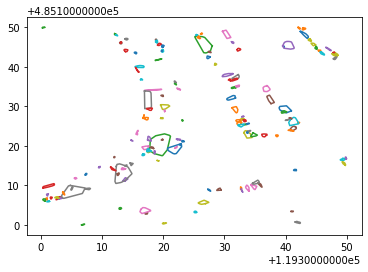

In [19]:
for obstacle in obstacles:
    x,y = obstacle.exterior.xy
    plt.plot(x,y)